In [1]:
import matplotlib.pyplot as plt
import anndata as adata
import scanpy as sc
import pandas as pd
from harmonypy import run_harmony

import snapatac2 as snap
import anndata as ad
import pandas as pd
import scanpy as sc
import scvi
import numpy as np

scvi.settings.seed = 0
snap.__version__
import warnings

warnings.filterwarnings("ignore")


/home/junyichen/anaconda3/envs/snapatac2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/junyichen/anaconda3/envs/snapatac2/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/junyichen/anaconda3/envs/snapatac2/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
INFO: Seed set to 0
2025-04-16 15:06:13 - INFO - Seed set to 0


In [2]:
import os
default_n_threads = 8
os.environ['OPENBLAS_NUM_THREADS'] = f"{default_n_threads}"
os.environ['MKL_NUM_THREADS'] = f"{default_n_threads}"
os.environ['OMP_NUM_THREADS'] = f"{default_n_threads}"

In [3]:
!export OPENBLAS_NUM_THREADS=8
!export MKL_NUM_THREADS=8
!export OMP_NUM_THREADS=8

# Read single cell data

In [4]:
adata_sc = adata.read_h5ad("/data1st1/hydata/SN_neuron_after_int_filter_anno.h5ad")
# Fix cell type 22 to neuron
# cluster_22_cells = adata_sc.obs_names[adata_sc.obs['Leiden_clusters_res1.0'] == '22']
# adata_sc.obs.loc[cluster_22_cells, 'celltype.L1'] = 'Neuron'

In [6]:
adata_sc = adata_sc[adata_sc.obs.region.isin(['AMY', 'HIP', 'PFC'])]

In [26]:
adata_sc

View of AnnData object with n_obs × n_vars = 305669 × 32285
    obs: 'key_0', 'sample', 'region', 'tech', 'donor', 'gender', 'status', 'folder', 'path', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'doublet_score', 'predicted_doublet', 'outlier', 'predicted_labels', 'conf_score', 'filter', 'trd', 'leiden', 'louvain', 'rt', 'louvain30', 'louvain5', 'louvain2', 'level1', 'level2', 'pred_mwb', 'vote_level1', 'vote_level2', 'capture_rate', 'index_', 'Unnamed: 0', 'celltype.L2'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'celltype.L2_colors', 'donor_colors', 'gender_colors', 'hvg', 'leiden', 'level1_colors', 'level2_colors', 'louvain', 'louvain2', 'louvain2_colors', 'louvain30', 'louvain30_colors', 'louvain5', 'louvain5_colors', 'louvain_colors', 

In [15]:
adata_sc.obs.columns

Index(['key_0', 'sample', 'region', 'tech', 'donor', 'gender', 'status',
       'folder', 'path', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'doublet_score', 'predicted_doublet',
       'outlier', 'predicted_labels', 'conf_score', 'filter', 'trd', 'leiden',
       'louvain', 'rt', 'louvain30', 'louvain5', 'louvain2', 'level1',
       'level2', 'pred_mwb', 'vote_level1', 'vote_level2', 'capture_rate',
       'index_', 'Unnamed: 0', 'celltype.L2'],
      dtype='object')

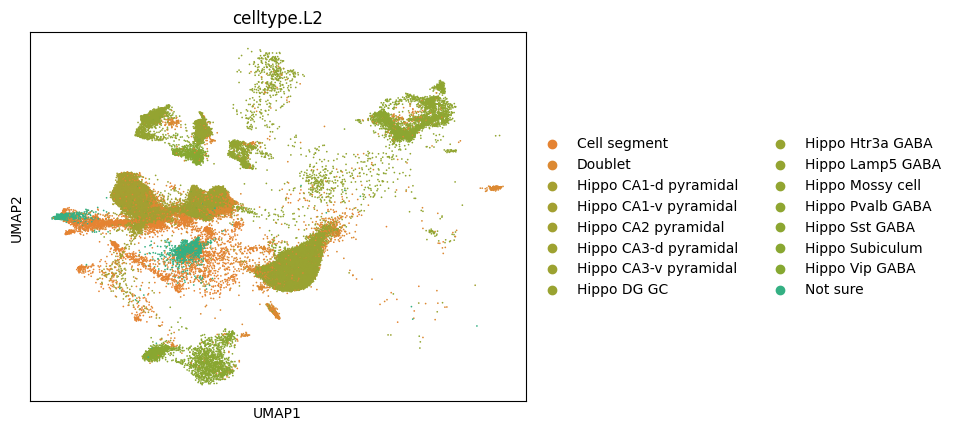

In [24]:
sc.pl.umap(adata_sc[adata_sc.obs.region.isin(['HIP'])], color=['celltype.L2'],size=6, show=True)

In [69]:
for region in adata_sc.obs['region'].unique()[:1]:
    adata_atac_region_neuron = sc.read_h5ad(f'/data2st1/junyi/output/atac0416/3REGIONS_gene_{region}_Neuron.h5ad')

In [58]:
adata_sc_region_neuron = adata_sc[adata_sc.obs.region.isin([region])]

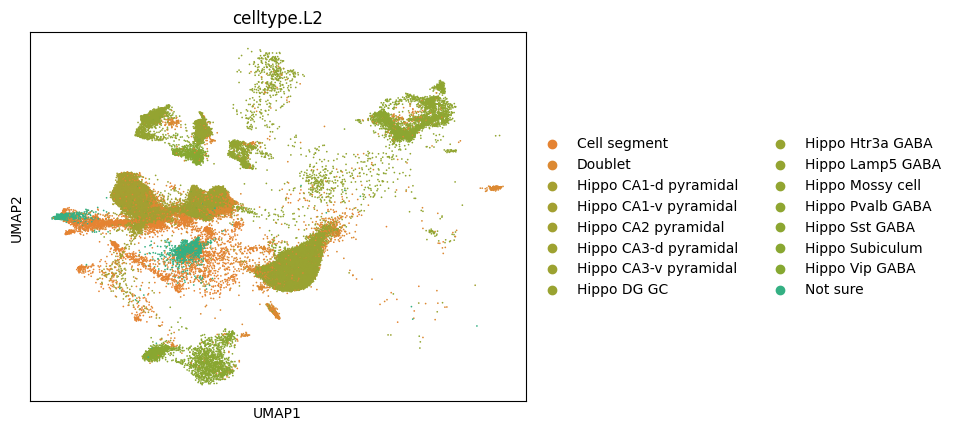

In [50]:
sc.pl.umap(adata_sc_region_neuron, color=['celltype.L2'],size=6, show=True)

In [71]:
adata_atac_region_neuron.X.max()

424.44198661955073

In [74]:
#sc.pp.normalize_per_cell(adata_atac_region_neuron)
adata_atac_region_neuron.obs

,sample,leiden,leiden_tile,celltype.L1,Region,Condition
MC39C_HIP:AAACGAAAGATGAGGA-1,MC39C_HIP,12,12,Neuron,HIP,MC
MC39C_HIP:AAACGAAAGGCTTAAA-1,MC39C_HIP,3,3,Neuron,HIP,MC
MC39C_HIP:AAACGAAAGGGACGTT-1,MC39C_HIP,3,3,Neuron,HIP,MC
MC39C_HIP:AAACGAAAGGTTCGTT-1,MC39C_HIP,4,4,Neuron,HIP,MC
MC39C_HIP:AAACGAAAGTCAACTC-1,MC39C_HIP,3,3,Neuron,HIP,MC
...,...,...,...,...,...,...
MW51A_HIP:TTTGTGTTCAAACCAC-1,MW51A_HIP,12,12,Neuron,HIP,MW
MW51A_HIP:TTTGTGTTCAGTCACA-1,MW51A_HIP,3,3,Neuron,HIP,MW
MW51A_HIP:TTTGTGTTCATTCTTG-1,MW51A_HIP,3,3,Neuron,HIP,MW
MW51A_HIP:TTTGTGTTCCGTTTCG-1,MW51A_HIP,4,4,Neuron,HIP,MW


In [73]:
n_top_genes = 5000

In [76]:
sc.pp.highly_variable_genes(adata_atac_region_neuron, n_top_genes=n_top_genes, batch_key="sample")


In [83]:
sc.pp.highly_variable_genes(adata_sc_region_neuron, n_top_genes=n_top_genes, batch_key="sample")

In [84]:
adata_sc_region_neuron

AnnData object with n_obs × n_vars = 92633 × 32285
    obs: 'key_0', 'sample', 'region', 'tech', 'donor', 'gender', 'status', 'folder', 'path', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'doublet_score', 'predicted_doublet', 'outlier', 'predicted_labels', 'conf_score', 'filter', 'trd', 'leiden', 'louvain', 'rt', 'louvain30', 'louvain5', 'louvain2', 'level1', 'level2', 'pred_mwb', 'vote_level1', 'vote_level2', 'capture_rate', 'index_', 'Unnamed: 0', 'celltype.L2'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'dispersions', 'dispersions_norm', 'highly_variable_intersection'
    uns: 'celltype.L2_colors', 'donor_colors', 'gender_colors', 'hvg', 'leiden', 'level1_colors', 'level2_colors', 'louvain', 'louvain2', 'louvain2_colors', 'louvain30', 'louvain30_

In [ ]:
query = adata_atac_region_neuron
reference = adata_sc_region_neuron
data = ad.concat(
    [reference, query],
    join='inner',
    label='batch',
    keys=["reference", "query"],
    index_unique='_',
)
data


In [ ]:
data = ad.concat(
    [reference, query],
    join='inner',
    label='batch',
    keys=["reference", "query"],
    index_unique='_',
)


In [ ]:
reference.obs

In [ ]:
data.obs

In [ ]:
import importlib
import scanpy as sc  # 首次导入
importlib.reload(sc)  # 重新加载


In [ ]:
sc.pp.filter_genes(data, min_cells=5)
sc.pp.highly_variable_genes(
    data,
    n_top_genes = 5000,
    flavor="seurat_v3",
    batch_key="batch",
    subset=True
)


In [ ]:
data

In [ ]:
# sc.pp.neighbors(adata_atac_selected)
# sc.tl.leiden(adata_atac_selected, resolution=1)
# sc.tl.umap(adata_atac_selected)
dump_embedding(adata_atac_selected, 'umap')


In [ ]:
dump_embedding(adata_atac_selected, 'umap')
#dump_embedding(adata_atac_selected, 'umap_seurat')


In [ ]:
fig, axes = plt.subplots(figsize=(12, 4), dpi=250, ncols=2)

ax = axes[0]
_ = categorical_scatter(data=adata_atac_selected.obs,
                        ax=ax,
                        coord_base='umap',
                        hue='leiden',
                        palette='tab20',
                        text_anno='leiden')
ax = axes[1]
_ = categorical_scatter(data=adata_atac_selected.obs,
                        ax=ax,
                        coord_base='umap',
                        hue='leiden',
                        palette='tab20',
                        text_anno='leiden')



In [ ]:
n_components = significant_pc_test(adata_atac_selected)


In [ ]:
fig, axes = plot_decomp_scatters(adata_atac_selected,
                                 n_components=n_components,
                                 hue=None,
                                 hue_quantile=(0.25, 0.75),
                                 nrows=5,
                                 ncols=5)

In [ ]:
adata_atac_selected.layers["counts"] = adata_atac_selected.X.copy()
sc.pp.normalize_total(adata_atac_selected)
# Logarithmize the data
sc.pp.log1p(adata_atac_selected)


In [ ]:
# n_genes = 10000
sc.pp.highly_variable_genes(adata_atac_selected, n_top_genes=n_genes, n_bins=20) 

In [ ]:
adata_atac_selected.var['gene_id'] = adata_atac_selected.var.index.str.split('.').str[0]

In [ ]:
adata_atac_selected.var.set_index('gene_id',inplace=True)

In [ ]:
# Preprocess the gene to ensemble id mapping
df_gene = pd.read_csv('/data2st1/junyi/generegion_vM33/genebody.bed',index_col=0,sep='\t',header=None)
df_gene_map = df_gene.iloc[:,[4,5]]
df_gene_map.columns = ['gene_id','gene_name']

df_gene_map.drop_duplicates(subset='gene_id',inplace=True)
df_result = df_gene_map.merge(adata_atac_selected.var,left_on='gene_id',right_index=True,how='right')
rows_with_missing_gene_name = df_result[df_result['gene_id'].isnull()]

df_result.loc[rows_with_missing_gene_name.index,'gene_id'] = df_result.loc[rows_with_missing_gene_name.index,'gene_name']

df_result['chr']= df_result.index
df_result.columns =['gene_name', 'gene_id', 'highly_variable', 'means', 'dispersions','dispersions_norm', 'chr']
df_result.set_index('gene_name',inplace=True)
df_result['gene_id'] = df_result['gene_id'].str.split('.').str[0]
df_result['gene_name'] = df_result.index

In [ ]:
df_result.loc[df_result.gene_id.isnull(),'gene_id'] = df_result.loc[df_result.gene_id.isnull(),'gene_name'] 

In [ ]:
adata_atac_selected.var = df_result.set_index('gene_id')

In [ ]:
adata_atac_selected.var_names_make_unique()

In [ ]:
sc.pp.highly_variable_genes(adata_sc, n_top_genes=n_genes, n_bins=20) 

In [ ]:
sc_hvf_list = adata_sc.var['dispersions_norm'].sort_values(ascending=False).dropna()[:n_genes].index
mcg_hvf_list = mcg.var['dispersions_norm'].sort_values(ascending=False).dropna()[:n_genes].index
mch_hvf_list = mch.var['dispersions_norm'].sort_values(ascending=False).dropna()[:n_genes].index
atac_hvf_list = adata_atac_selected.var['dispersions_norm'].sort_values(ascending=False).dropna()[:n_genes].index


In [ ]:
atac_hvf_list

In [ ]:
hvfs = mcg_hvf_list.intersection(sc_hvf_list).intersection(mcg_hvf_list).intersection(atac_hvf_list)

In [ ]:
adata_sc_selected = adata_sc

In [ ]:
sc_hvf_adata = adata_sc_selected[:,hvfs].copy()
sc.pp.scale(sc_hvf_adata)
sc_hvf_adata

In [ ]:
mcg.var.index = mcg.var.index.astype(str)
mcg.obs.index = mcg.obs.index.astype(str)
mch.var.index = mch.var.index.astype(str)
mch.obs.index = mch.obs.index.astype(str)

In [ ]:
mcg_hvf_adata = mcg[:,hvfs].copy()
sc.pp.scale(mcg_hvf_adata)
mcg_hvf_adata.X *=-1

In [ ]:
mch_hvf_adata = mch[:,hvfs].copy()
sc.pp.scale(mch_hvf_adata)
mch_hvf_adata.X *=-1

In [ ]:
from ALLCools.pseudo_cell import generate_pseudo_cells_kmeans

adata_atac_pseudo = generate_pseudo_cells_kmeans(adata_atac_selected,
                                            cluster_col='leiden',
                                            obsm='X_pca',
                                            cluster_size_cutoff=100,
                                            max_pseudo_size=50,
                                            aggregate_func='downsample')


In [ ]:
adata_atac_pseudo
sc.pp.normalize_per_cell(adata_atac_pseudo)
sc.pp.log1p(adata_atac_pseudo)

In [ ]:
sc.pp.highly_variable_genes(adata_atac_pseudo, n_top_genes=10000, n_bins=100)
sc.pl.highly_variable_genes(adata_atac_pseudo)
test_adata = adata_atac_pseudo[:, adata_atac_pseudo.var['highly_variable']].copy()


In [ ]:
sc.pp.scale(test_adata)
sc.tl.pca(test_adata)
sc.pp.neighbors(test_adata)
sc.tl.umap(test_adata)
sc.tl.leiden(test_adata)
test_adata.obs['group'] = test_adata.obs_names.map(lambda i: '.'.join(i.split('.')[:2]))

In [ ]:
test_adata.obs['lenden_snap'] = adata_atac_pseudo.obs['leiden']

In [ ]:
sc.pl.umap(test_adata, color=['leiden','ENSMUSG00000076439'],size=150)

In [ ]:
sc.pl.umap(adata_atac_selected, color=['leiden'],size=150) 

In [ ]:
adata_atac_pseudo.obs['leiden_snap'] = adata_atac_pseudo.obs['leiden']

In [ ]:
adata_atac_pseudo.write_h5ad(f'output/ATAC.PseudoCellAdata.3regions.h5ad')

In [ ]:
adata_sc_pseudo = generate_pseudo_cells_kmeans(adata_sc,
                                            cluster_col='celltype.L1',
                                            obsm='X_pca',
                                            cluster_size_cutoff=100,
                                            max_pseudo_size=50,
                                            aggregate_func='downsample')

In [ ]:
adata_sc_pseudo

In [ ]:
sc.pp.normalize_per_cell(adata_sc_pseudo)
sc.pp.log1p(adata_sc_pseudo)

sc.pp.highly_variable_genes(adata_sc_pseudo, n_top_genes=10000, n_bins=100)
sc.pl.highly_variable_genes(adata_sc_pseudo)
test_adata = adata_sc_pseudo[:, adata_sc_pseudo.var['highly_variable']].copy()


In [ ]:
# remove low cov gene
adata_sc_pseudo.write_h5ad(f'output/PseudoCellAdata.3regions.h5ad')


In [ ]:
sc.pp.scale(test_adata)
sc.tl.pca(test_adata)
sc.pp.neighbors(test_adata)
sc.tl.umap(test_adata)
sc.tl.leiden(test_adata)


In [ ]:
sc.pl.umap(adata_sc, color=['celltype.L1'],size=50)

In [ ]:
sc.pl.umap(test_adata, color=['leiden','celltype.L1'],size=50)

In [ ]:
adata_atac_selected.obs.to_csv('output/ATAC.3regions.MetaData.csv.gz')
adata_sc_selected.obs.to_csv('output/Brain.3regions.MetaData.csv.gz')

In [ ]:
atac_hvf_adata = adata_atac_selected[:,hvfs].copy()
sc.pp.scale(atac_hvf_adata)

In [ ]:
adata_concat = sc_hvf_adata.concatenate([
    mcg_hvf_adata,
    mch_hvf_adata,
    atac_hvf_adata
    
],
                                index_unique='-')
adata_concat.obs['batch'] = adata_concat.obs['batch'].map({
    '0': 'sc',
    '1': 'mcg',
    '2': 'mch',
    '3': 'atac'
    })
adata_concat

In [ ]:
sc.pp.pca(adata_concat, n_comps=50)
sc.pl.pca_variance_ratio(adata_concat)
n_components = significant_pc_test(adata_concat, p_cutoff=0.2)


In [ ]:
adata_concat.obs['predicted_doublet'].fillna('False',inplace=True)
adata_concat.obs["predicted_doublet"] = adata_concat.obs["predicted_doublet"].astype(bool)

adata_concat.var['mt-0'] = adata_concat.var["mt-0"].astype(bool)
#adata_concat.var['highly_variable-0-0'] = adata_concat.var["highly_variable-0-0"].astype(bool)
#adata_concat.var['highly_variable-1-0'] = adata_concat.var["highly_variable-1-0"].astype(bool)
#adata_concat.var['highly_variable-0'] = adata_concat.var["highly_variable-0"].astype(bool)

adata_concat.obs['PassBasicQC'] = adata_concat.obs["PassBasicQC"].astype(bool)


In [ ]:
adata_concat.write_h5ad('output/merged-3region-concat-clustering.h5ad')

In [ ]:
scps_hvf_list = adata_sc_pseudo.var['dispersions_norm'].sort_values(ascending=False).dropna()[:n_genes].index
atacps_hvf_list = adata_atac_pseudo.var['dispersions_norm'].sort_values(ascending=False).dropna()[:n_genes].index


In [ ]:
hvfs = mcg_hvf_list.intersection(scps_hvf_list).intersection(mcg_hvf_list).intersection(atacps_hvf_list)

In [ ]:
len(hvfs)

In [ ]:
sc_hvf_pseudo_adata = adata_sc_pseudo[:,hvfs].copy()
atac_hvf_pseudo_adata = adata_atac_pseudo[:,hvfs].copy()

mcg_hvf_pseudo_adata = mcg[:,hvfs].copy()
mch_hvf_pseudo_adata  = mch[:,hvfs].copy()

In [ ]:
adata_pse_concat = sc_hvf_pseudo_adata.concatenate([
    mcg_hvf_pseudo_adata,
    mch_hvf_pseudo_adata,
    atac_hvf_pseudo_adata
    
],
                                index_unique='-')
adata_pse_concat.obs['batch'] = adata_pse_concat.obs['batch'].map({
    '0': 'sc',
    '1': 'mcg',
    '2': 'mch',
    '3': 'atac'
    })
adata_pse_concat

In [ ]:
sc.pp.pca(adata_pse_concat, n_comps=50)
sc.pl.pca_variance_ratio(adata_pse_concat)
n_components = significant_pc_test(adata_pse_concat, p_cutoff=0.2)


In [ ]:
#adata_pse_concat.obs['predicted_doublet'].fillna('False',inplace=True)
#adata_pse_concat.obs["predicted_doublet"] = adata_pse_concat.obs["predicted_doublet"].astype(bool)

adata_pse_concat.var['mt-0'] = adata_pse_concat.var["mt-0"].astype(bool)
#adata_concat.var['highly_variable-0-0'] = adata_concat.var["highly_variable-0-0"].astype(bool)
#adata_concat.var['highly_variable-1-0'] = adata_concat.var["highly_variable-1-0"].astype(bool)
#adata_concat.var['highly_variable-0'] = adata_concat.var["highly_variable-0"].astype(bool)

adata_pse_concat.obs['PassBasicQC'] = adata_pse_concat.obs["PassBasicQC"].astype(bool)


In [ ]:
adata_pse_concat.write_h5ad('output/merged-3region-pseudo-clustering.h5ad')

In [ ]:
atacsn = scps_hvf_list.intersection(atacps_hvf_list)

In [ ]:
pse_atac = adata_atac_pseudo[:,atacsn].copy()
pse_sc = adata_sc_pseudo[:,atacsn].copy()

In [ ]:
adata_pse_concat = pse_atac.concatenate([
    pse_sc    
],
                                index_unique='-')
adata_pse_concat.obs['batch'] = adata_pse_concat.obs['batch'].map({
    '0': 'sc',
    '1': 'atac'
    })
adata_pse_concat

In [ ]:
sc.pp.pca(adata_pse_concat, n_comps=50)
sc.pl.pca_variance_ratio(adata_pse_concat)
n_components = significant_pc_test(adata_pse_concat, p_cutoff=0.2)


In [ ]:
adata_pse_concat.write_h5ad('output/atacsc-3region-pseudo-clustering.h5ad')

In [ ]:
atacsn = sc_hvf_list.intersection(atac_hvf_list)

In [ ]:
sub_atac = adata_atac_selected[:,atacsn].copy()
sub_sc = adata_sc[:,atacsn].copy()

In [ ]:
adata_sub_concat = sub_sc.concatenate([
    sub_atac    
],
                                index_unique='-')
adata_sub_concat.obs['batch'] = adata_sub_concat.obs['batch'].map({
    '0': 'sc',
    '1': 'atac'
    })
adata_sub_concat

In [ ]:
#adata_pse_concat.obs['predicted_doublet'].fillna('False',inplace=True)
#adata_pse_concat.obs["predicted_doublet"] = adata_pse_concat.obs["predicted_doublet"].astype(bool)

adata_sub_concat.var['mt-0'] = adata_sub_concat.var["mt-0"].astype(bool)
#adata_concat.var['highly_variable-0-0'] = adata_concat.var["highly_variable-0-0"].astype(bool)
#adata_concat.var['highly_variable-1-0'] = adata_concat.var["highly_variable-1-0"].astype(bool)
#adata_concat.var['highly_variable-0'] = adata_concat.var["highly_variable-0"].astype(bool)

#adata_sub_concat.obs['PassBasicQC'] = adata_sub_concat.obs["PassBasicQC"].astype(bool)


In [ ]:
adata_sub_concat.write_h5ad('output/atacsc-3region-clustering.h5ad')

In [ ]:
sc.pp.neighbors(adata_concat, n_neighbors=5)
sc.tl.leiden(adata_concat, resolution=1.5)
sc.tl.umap(adata_concat)


In [ ]:
_ = plot_decomp_scatters(adata_concat,
                         n_components=n_components,
                         hue='batch',
                         palette='tab10')

In [ ]:
adata_concat.obs['umap_0'] = adata_concat.obsm['X_umap'][:, 0]
adata_concat.obs['umap_1'] = adata_concat.obsm['X_umap'][:, 1]


In [ ]:
fig, axes = plt.subplots(figsize=(8, 3), dpi=250, ncols=2)

ax = axes[0]
categorical_scatter(ax=ax,
                    data=adata_concat,
                    hue='batch',
                    show_legend=True,
                    max_points=None,
                    s=1)

ax = axes[1]
categorical_scatter(ax=ax,
                    data=adata_concat,
                    hue='pred_Class',
                    show_legend=True,
                    max_points=None,
                    s=1)

In [ ]:
adata_concat.obs.columns

In [ ]:
adata_concat.obs[adata_concat.obs['batch'] == 'mcg'].copy().columns

In [ ]:
fig, axes = plt.subplots(figsize=(8, 3), dpi=250, ncols=2)

data = adata_concat.obs[adata_concat.obs['batch'] == 'mcg'].copy()
#data['MajorType'] = data['SubType'].str.split('_').str[-1]
data2 = adata_concat.obs[adata_concat.obs['batch'] == 'atac'].copy()


ax = axes[0]
categorical_scatter(ax=ax,
                    data=data,
                    show_legend=False,
                    max_points=None,
                    hue='SubRegion',
                    text_anno='SubRegion',
                    s=1)

ax = axes[1]
categorical_scatter(ax=ax,
                    data=data2,
                    hue='leiden',
                    show_legend=True,
                    text_anno='leiden',

                    max_points=None,
                    s=1)

In [ ]:
adata_sc.obs.columns

In [ ]:
df_pred_class=pd.DataFrame(pd.crosstab(adata_concat.obs['pred_Class'], adata_concat.obs['leiden']).idxmax())

In [ ]:
df_class=pd.DataFrame(pd.crosstab(adata_concat.obs['Class'], adata_concat.obs['leiden']).idxmax())

In [ ]:
df_type_merged = df_pred_class.merge(df_class,how='outer',left_index=True,right_index=True).fillna(method='ffill').fillna(method='bfill')
df_type_merged.columns = ['pred_Class','Class']

In [ ]:
lei_map_class = dict(zip(df_type_merged.index,df_type_merged['Class']))
lei_map_pred_class = dict(zip(df_type_merged.index,df_type_merged['pred_Class']))

In [ ]:
adata_concat.obs

In [ ]:
adata_concat.obs

In [ ]:
mapped_class = []
mappled_preclass = []
for inde,row in (adata_concat.obs).iterrows():
    if row['leiden'] not in lei_map_class:
        mapped_class.append(row['leiden'])
        mappled_preclass.append(row['leiden'])
    else:
        mapped_class.append(lei_map_class[row['leiden']])
        mappled_preclass.append(lei_map_pred_class[row['leiden']])  


In [ ]:
adata_concat.obs['mapped_class'] = mapped_class
adata_concat.obs['mappled_preclass'] = mappled_preclass

In [ ]:
interactive_scatter(data=adata_concat,
                    hue='mappled_preclass',
                    coord_base='umap',
                    max_points=20000)

In [ ]:
interactive_scatter(data=adata_concat,
                    hue='mappled_preclass',
                    coord_base='umap',
                    max_points=10000)

In [ ]:
adata_concat.obs

In [ ]:
sc._utils.sanitize_anndata(adata_concat)

In [ ]:
adata_concat.obs['predicted_doublet'].fillna('False',inplace=True)
adata_concat.obs["predicted_doublet"] = adata_concat.obs["predicted_doublet"].astype(bool)

adata_concat.var['mt-0'] = adata_concat.var["mt-0"].astype(bool)
adata_concat.var['highly_variable-0-0'] = adata_concat.var["highly_variable-0-0"].astype(bool)
adata_concat.var['highly_variable-1-0'] = adata_concat.var["highly_variable-1-0"].astype(bool)
adata_concat.var['highly_variable-0'] = adata_concat.var["highly_variable-0"].astype(bool)


In [ ]:
adata_concat.write_h5ad('output/merged-clustering.h5ad')